# BIKE SHARING DEMAND

## 问题背景与字段介绍

在本次比赛中,参与者被要求将历史使用模式与天气数据相结合,以预测华盛顿特区Capital Bikeshare计划中的自行车租赁需求
涉及的字段有12个：
1. datetime：包含了月、r2_score、时的时间数据
2. season：用1234分别表示春夏秋冬
3. holiday：这一天是否是假日
4. workingday：这一天是否既不是周末也不是假日
5. weather：使用1234表示四种不同的天气
6. temp：摄氏温度
7. atemp：体感摄氏温度
8. humidity：湿度
9. windspeed：风速
10. casual：非注册用户租车数
11. registered：注册用户租车数
12. count：总租车数

阅读了以上内容后，我有如下思考：
1. 题目中指明我们要预测华盛顿特区的自行车租赁需求，华盛顿特区这个地点作为已知条件，其气候特征、人文特征等可能有助于预测。
2. datetime字段形式上不适用于传入预测模型，应当将该特征转化为方便训练的形式
3. season字段使用1234表示四季，但四季之间不存在大小关系，故应采用独热编码
4. 英文中的holiday不包括周末，而workingday的定义指明了workingday是除去周末和holiday的日子。我结合经验猜测在workingday中很多人有上班通勤的需求，holiday可能会在家或出游，weekend更可能是在家。
5. weather字段使用1234表示不同的天气，原则上不同的天气也不应当有大小关系，应当采用独热编码。但结合不同天气的描述，我发现从1到4是从晴朗干燥到多云潮湿到小雨小雪再到大雨大雪大雾天气的变化，似乎越来越不适合骑共享单车出行，因此似乎存在排序关系。
6. 体感温度受到温度、湿度和风速的综合影响。同时体感温度直接作用在用户的身体感受上，相对于客观温度似乎更容易对租车意愿产生影响。另外温度、湿度、风速、体感温度这些数据是连续值，可以通过分箱进行离散化处理。
7. 在训练集数据中总的租车人数被分为注册和非注册用户两类，我不确定这里面的注册与非注册的具体含义，结合我自己的经验，注册用户类似于买了月卡的用户，这类用户租车的意愿相对更强一些。从后面的数据分析中可以看到，租车用户中注册用户占了多数，我认为可以推测出的结论是长期来看租车人数具有一定的稳定性。

## 华盛顿特区气候特征
我从互联网上找到了华盛顿特区2011年的气候特征
### 每小时气温
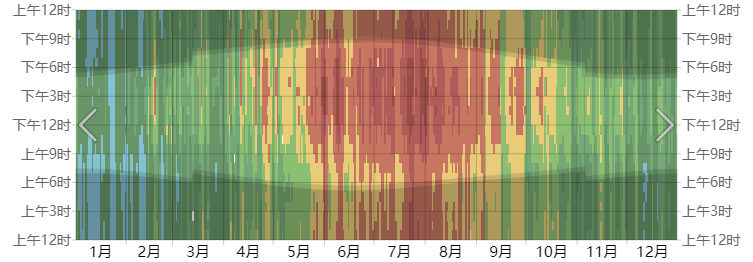
### 温度历史
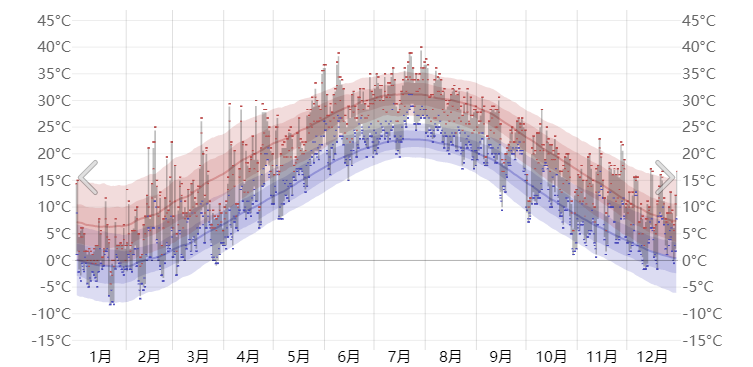
### 每日降水
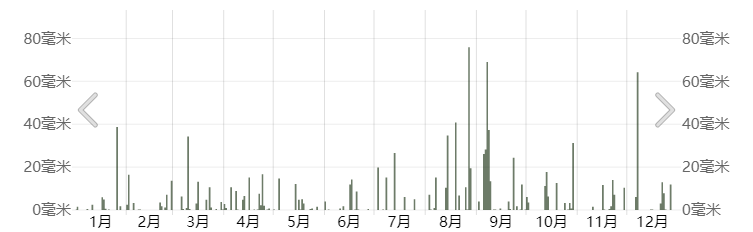
### 积雪厚度
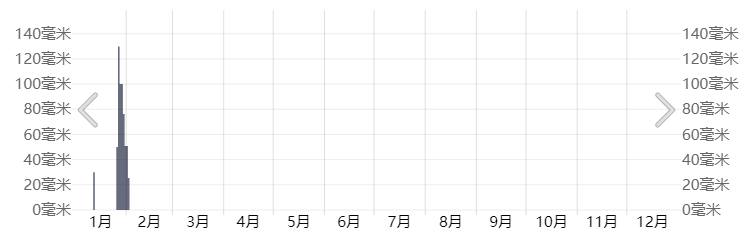
### 日出日落时间
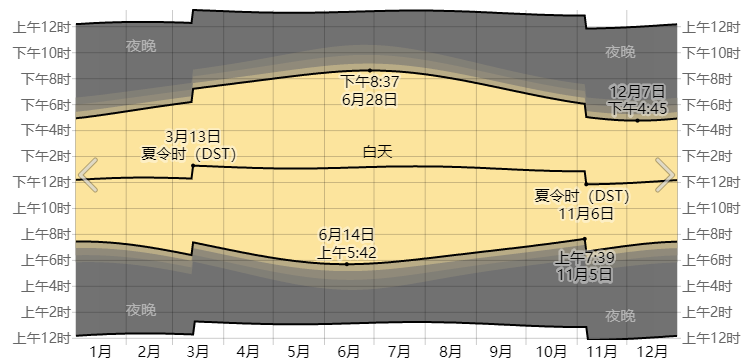
### 湿度舒适水平
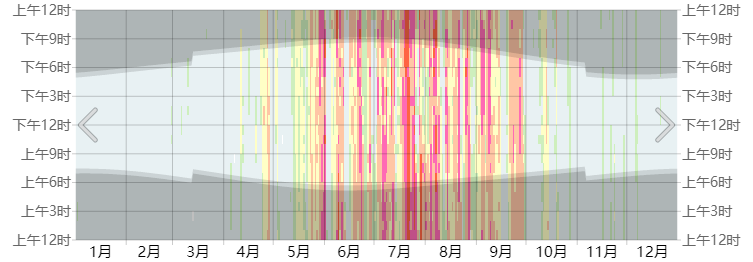
### 风速
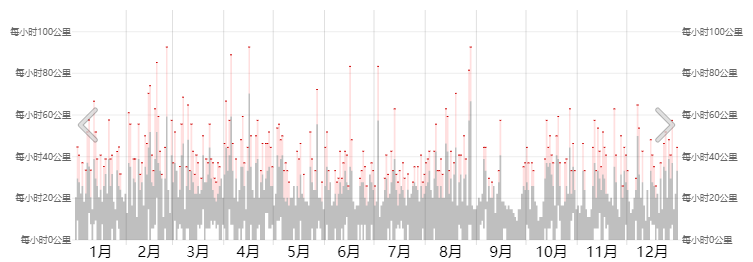
可以得到以下几点信息：
1. 六月初到八月末的白天尤其是下午温度较高
2. 一月和二月有一部分时间最低气温低于零摄氏度，且一月末二月初存在积雪
3. 降水总体上看比较均匀，八九月份降水较多
4. 六月初到九月末会进入潮湿状态，尤其是七月份非常潮湿
5. 风速上全年变化不大，偶尔会有大风天气

## 包库引入与数据读取

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

In [ ]:
ori_train=pd.read_csv('../input/bike-sharing-demand/train.csv')
ori_test=pd.read_csv('../input/bike-sharing-demand/test.csv')

## 数据概览与缺失值检查

In [ ]:
ori_train.head()

In [ ]:
ori_train.info()

In [ ]:
ori_train.isnull().sum()

可以看到原数据没有缺失值，可能是数据在交给我们之前已经做过缺失值处理了。

## 数据分析处理与可视化

In [ ]:
ori_train.describe()

温度、体感温度、风速和湿度均为连续数据，通过直方图了解一下这些数据的分布情况

In [ ]:
ori_train.temp.unique()
fig,axes=plt.subplots(2,2)

axes[0,0].hist(x="temp",data=ori_train,edgecolor="black",linewidth=2,color='red')
axes[0,0].set_title("temp")
axes[0,1].hist(x="atemp",data=ori_train,edgecolor="black",linewidth=2,color='green')
axes[0,1].set_title("atemp")
axes[1,0].hist(x="windspeed",data=ori_train,edgecolor="black",linewidth=2,color='purple')
axes[1,0].set_title("windspeed")
axes[1,1].hist(x="humidity",data=ori_train,edgecolor="black",linewidth=2,color='pink')
axes[1,1].set_title("humidity")

fig.set_size_inches(10,8)

通过热力图了解不同特征之间的相关性

In [ ]:
cor_mat= ori_train[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True,linewidths=0.5,cmap="YlGnBu")

下面对季节进行独热编码，对天气采用独热编码后准确度反而降低，因此对天气不采用独热编码

In [ ]:
#对季节进行独热编码
seasons=pd.get_dummies(ori_train['season'],prefix='season')
train=pd.concat([ori_train,seasons],axis=1)
#weathers=pd.get_dummies(train['weather'],prefix='weather')
#train=pd.concat([train,weathers],axis=1)
#train.drop(['season','weather'],inplace=True,axis=1)

seasons=pd.get_dummies(ori_test['season'],prefix='season')
test=pd.concat([ori_test,seasons],axis=1)
#weathers=pd.get_dummies(test['weather'],prefix='weather')
#test=pd.concat([test,weathers],axis=1)
#test.drop(['season','weather'],inplace=True,axis=1)

train.head()

下面处理datetime字段的格式问题，将其拆分为hour、day、month、year四个字段，其中年份的2011和2012可用0和1来表示。

In [ ]:
#拆分日期时间
train['hour']=[t.hour for t in pd.DatetimeIndex(train.datetime)]
train['day']=[t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train['month']=[t.month for t in pd.DatetimeIndex(train.datetime)]
train['year']=[t.year for t in pd.DatetimeIndex(train.datetime)]
train['year']=train['year'].map({2011:0,2012:1})
train.drop('datetime',axis=1,inplace=True)
train.drop(['casual','registered'],axis=1,inplace=True)


test['hour']=[t.hour for t in pd.DatetimeIndex(test.datetime)]
test['day']=[t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test['month']=[t.month for t in pd.DatetimeIndex(test.datetime)]
test['year']=[t.year for t in pd.DatetimeIndex(test.datetime)]
test['year']=test['year'].map({2011:0,2012:1})

train.head()

考虑到雨天雪天对共享单车租赁的影响并不局限于当天。雨天雪天后一方面道路可能积水积雪，另一方面可能存在车座潮湿的问题，会导致共享单车的租赁量降低。因此我们构造一个新特征new_feature，小雨小雪天气出现时，当天和下一天的new_feature置为1；大雨大雪天气出现时，当天、下一天和下下一天的new_feature置为1，其余的newfeature默认为0.下面构造该特征：

In [ ]:
train['new_feature']=0
test['new_feature']=0
for index,row in train.iterrows():
    if row['weather']==3:
        #将自己这一行和下一行的new_feature设为1
        train['new_feature'].iloc[index]=1
        if index<len(train)-1:
            train['new_feature'].iloc[index+1]=1
    elif row['weather']==4:
        #将自己这一行和下面两行的new_feature设为1
        train['new_feature'].iloc[index]=1
        if index<len(train)-1:
            train['new_feature'].iloc[index+1]=1
        if index<len(train)-2:
            train['new_feature'].iloc[index+2]=1
            
for index,row in test.iterrows():
    if row['weather']==3:
        #将自己这一行和下一行的new_feature设为1
        test['new_feature'].iloc[index]=1
        if index<len(train)-1:
            test['new_feature'].iloc[index+1]=1
    elif row['weather']==4:
        #将自己这一行和下面两行的new_feature设为1
        test['new_feature'].iloc[index]=1
        if index<len(train)-1:
            test['new_feature'].iloc[index+1]=1
        if index<len(train)-2:
            test['new_feature'].iloc[index+2]=1

In [ ]:
cor_mat= train[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True,linewidths=0.5,cmap="YlGnBu")

这里考虑count值随一天中的时间变化情况，可以发现，周末和平时count值随时间变化有明显不同

In [ ]:
sns.factorplot(x="hour",y="count",data=train,kind='bar',size=5,aspect=1.5)

In [ ]:
train_1=train.query('day>=0 & day<=4')
sns.factorplot(x="hour",y="count",data=train_1,kind='bar',size=5,aspect=1.5)

In [ ]:
train_2=train.query('day>=5 & day<=6')
sns.factorplot(x="hour",y="count",data=train_2,kind='bar',size=5,aspect=1.5)

In [ ]:
sns.factorplot(x="month",y="count",data=train,kind='bar',size=5,aspect=1.5)

In [ ]:
sns.factorplot(x="year",y="count",data=train,kind='bar',size=5,aspect=1.5)

In [ ]:
sns.factorplot(x="day",y='count',kind='bar',data=train,size=5,aspect=1)

In [ ]:
#开始建立模型
train.columns.to_series().groupby(train.dtypes).groups

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(train.drop('count',axis=1),train['count'],test_size=0.25,random_state=42)

尝试常见的回归模型，使用MSLE评价模型（与提交系统的评估方式相同）

In [ ]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','KNeighborsRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)
    rmsle.append(mean_squared_log_error(test_pred,y_test))
d={'Modelling Algo':model_names,'RMSLE':rmsle}
d

In [ ]:
rmsle_frame=pd.DataFrame(d)
rmsle_frame

对表现最好的两种模型进行调参

In [ ]:
no_of_test=[500]
params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(x_train,y_train)
pred_rf=clf_rf.predict(x_test)
print((np.sqrt(mean_squared_log_error(pred_rf,y_test))))

In [ ]:
clf_rf.best_params_

In [ ]:
# BR

params_dict={"max_samples": [0.5, 1.0],
             "max_features": [0.5, 1.0],
             "bootstrap": [True, False],
             "bootstrap_features": [True, False]}
clf_BR=GridSearchCV(estimator=BaggingRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_BR.fit(x_train,y_train)
pred_br=clf_BR.predict(x_test)
print((np.sqrt(mean_squared_log_error(pred_br,y_test))))

In [ ]:
clf_BR.best_params_

输出结果

In [ ]:
pred_rf=clf_rf.predict(test.drop('datetime',axis=1))
pred_br=clf_BR.predict(test.drop('datetime',axis=1))
pred=0.5*pred_br+0.5*pred_rf
d={'datetime':test['datetime'],'count':pred}
ans=pd.DataFrame(d)
ans.to_csv('answer.csv',index=False)